In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

DATAPATH = "Azure_Dataset/azure.csv"

In [5]:
data = pd.read_csv(DATAPATH, index_col=["timestamp"], parse_dates=["timestamp"])
data.head(10)

,min cpu,max cpu,avg cpu
timestamp,,,
2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06
2017-01-01 00:25:00,691089.138618,2.284282e+06,1.220289e+06
2017-01-01 00:30:00,683834.767717,2.200116e+06,1.192508e+06
2017-01-01 00:35:00,671049.329203,2.173881e+06,1.164390e+06
2017-01-01 00:40:00,668678.420129,2.171679e+06,1.163262e+06


# EDA

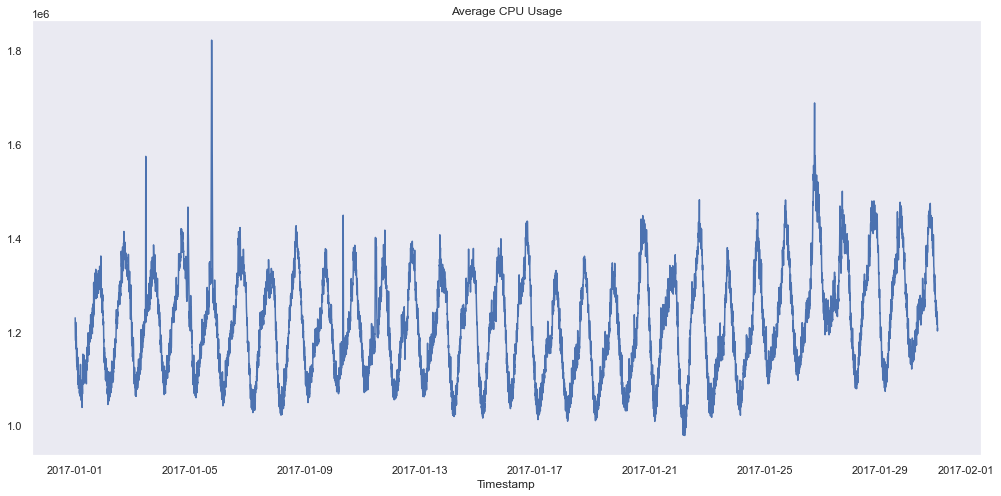

In [6]:
plt.figure(figsize=(17, 8))
plt.plot(data["avg cpu"])
plt.title('Average CPU Usage')
plt.xlabel('Timestamp')
plt.grid(False)
plt.show()

# Moving average
Let’s use the moving average model to smooth our time series. For that, we will use a helper function that will run the moving average model on a specified time window and it will plot the result smoothed curve:

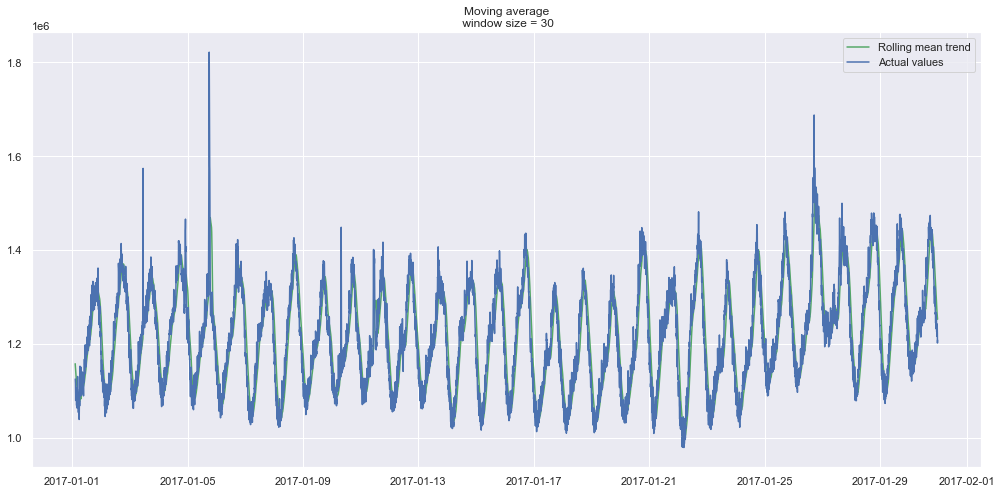

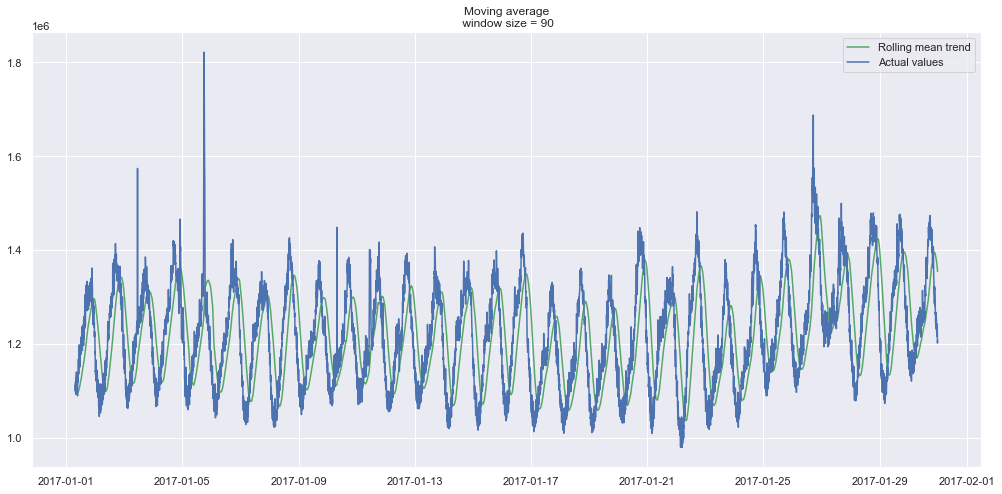

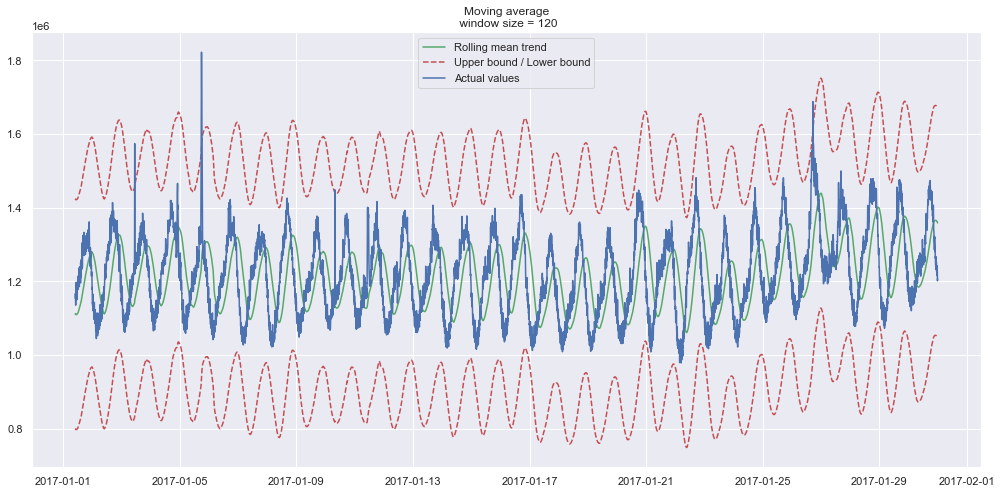

In [14]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data["avg cpu"], 30)

#Smooth by the previous month (30 days)
plot_moving_average(data["avg cpu"], 90)

#Smooth by previous quarter (90 days)
plot_moving_average(data["avg cpu"], 120, plot_intervals=True)

# Exponential smoothing

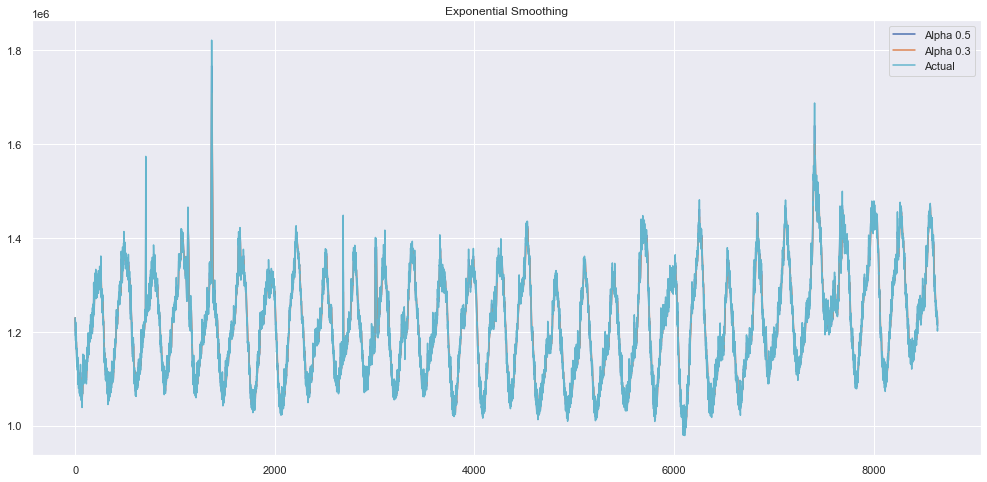

In [17]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data["avg cpu"], [0.5, 0.3])

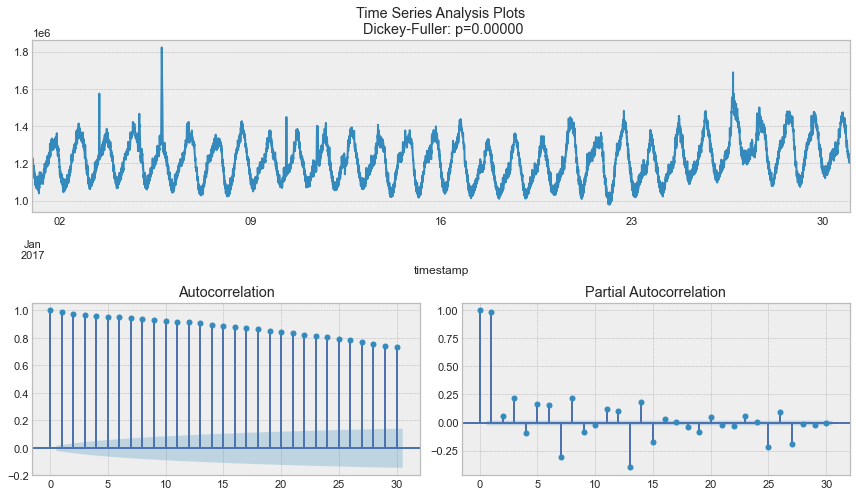

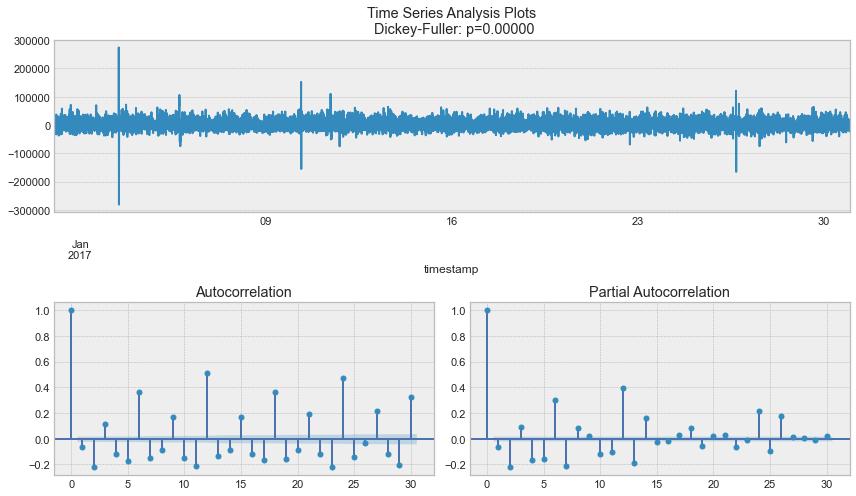

In [18]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data["avg cpu"], lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data["avg cpu"] - data["avg cpu"].shift(1)

tsplot(data_diff[1:], lags=30)

In [7]:

#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data["avg cpu"], order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data["avg cpu"], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775